# Data Management and Reproducibility


### Directory structure for a project - organizational suggestions

`/data/raw/` - immutable. never change these files 

`/code` or `/scripts` 

`/tmp` - temporary folder i.e. "scratch paper" 

`/data/clean/` - post-processed data 

`/figures`  

git workflow - save the code and the outputs for sure. if the inputs are large, make sure you have a system for dealing with large data. do not keep temp data (.gitignore) 


In [ ]:
#### Create folders in terminal

### Reproducibility in Jupyter Notebooks  

Notebooks are a really great tool. They use REPL for data exploration, plotting, prototyping. 

REPL  -  Read-Evaluate-Print Loop (see the output of code inline) 
 
However, notebooks can be problematic because when you're exploring the data, you can run cells out of order or delete cells with downstream dependencies. This is one reason why professional software developers like to write and test entire scripts instead of line-by-line analysis.

In [2]:
# Toy example of cell execution order problems

x=3
print(x)

3


In [5]:
y=2*x
print(y)

4


In [4]:
x=2

One way to ensure reproducibility is to go up to the `Kernel` menu and click on `Restart and Run All` to make sure that your notebook is **Linearized** and runs properly when all the cells are executed in order

Another option would be to use an IDE to develop reproducible scripts and group scripts and notebooks together in projects. Examples of IDEs: 

 - Atom
 - Sublime
 - Vim/nano/emacs/notepad++ 
 - pycharm 
 - RStudio
 - Jupyter Lab 
 
 
 Advantages of IDEs include syntax highlighting, code completion, linting, and integrations with git(hub) and other tools. 
 
 

### Loading data

* From files (csv, txt, etc.) 
    - Our example
* REST api (REpresentational State Transfer)
    - Example: twitteR, Neon 
* wget/cURL 
    - Example: DataDryad, Retriever, NASA SEDAC 
* From database (mention only, no example)
    - Example: GDELT/BLAST

#### Neon data manual browsing

http://data.neonscience.org/browse-data?showAllDates=true&showAllSites=true&showTheme=org

In [6]:
import requests

# must redo API call each time to make sure the download link is authorized and up to date 
base_url = 'http://data.neonscience.org/api/v0'
endpoint = 'data'
product_code= 'DP1.00098.001' # relative humidity 
site_code = 'ABBY' 
year_month = '2016-07'
package = '?package=basic'

api_call = str.join('/',[base_url,endpoint,product_code,site_code,year_month,package])
print(api_call)
r=requests.get(api_call)

http://data.neonscience.org/api/v0/data/DP1.00098.001/ABBY/2016-07/?package=basic


In [17]:
url=r.json()['data']['files'][1]['url']

#### wget example

In [13]:
url.split('?')[0]

'https://neon-prod-pub-1.s3.data.neonscience.org/NEON.DOM.SITE.DP1.00098.001/PROV/ABBY/20160701T000000--20160801T000000/basic/NEON.D16.ABBY.DP1.00098.001.000.040.001.RH_1min.2016-07.basic.20171026T093814Z.csv'

In [16]:
import os
os.system('wget '+url.split('?')[0])

0

In [18]:
import urllib.request
import shutil

file_name='ABBY_rel_humid_2016-07_RAW.csv' # distinguish raw data 

# Download the file from `url` and save it locally under `file_name`:
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)


### Preprocessing input data 

Need to deal with: 
- null values (missing data) 

1) collect more data 

2) imputation 

3) subsetting 


- data types = categorical vs. ordinal. str vs int vs. boolean 

- Sampling bias - how do we know our data is representative of the underlying system? when repeated sampling gives the same distribution (this is the essence of sample size analysis). Also depends on definition of "same" and how you measure it (assumptino of gaussian?) 

In [19]:
import pandas as pd
df = pd.read_csv('ABBY_rel_humid_2016-07_RAW.csv')
print(df.shape)
df.head()

(44641, 26)


,startDateTime,endDateTime,RHMean,RHMinimum,RHMaximum,RHVariance,RHNumPts,RHExpUncert,RHStdErMean,RHFinalQF,...,tempRHStdErMean,tempRHFinalQF,dewTempMean,dewTempMinimum,dewTempMaximum,dewTempVariance,dewTempNumPts,dewTempExpUncert,dewTempStdErMean,dewTempFinalQF
0,2016-06-30T23:59:00Z,2016-07-01T00:00:00Z,58.67,58.28,59.28,0.11,60.0,2.2,0.04,0,...,0.003,0,12.835,12.72,13.00,0.008,60.0,0.249,0.012,0
1,2016-07-01T00:00:00Z,2016-07-01T00:01:00Z,57.65,57.39,58.28,0.06,60.0,2.2,0.03,0,...,0.005,0,12.571,12.50,12.77,0.004,60.0,0.252,0.008,0
2,2016-07-01T00:01:00Z,2016-07-01T00:02:00Z,58.14,57.92,58.43,0.04,60.0,2.2,0.02,0,...,0.003,0,12.584,12.53,12.66,0.002,60.0,0.249,0.006,0
3,2016-07-01T00:02:00Z,2016-07-01T00:03:00Z,58.65,58.07,59.39,0.23,58.0,2.2,0.06,0,...,0.001,0,12.673,12.53,12.87,0.015,58.0,0.251,0.016,0
4,2016-07-01T00:03:00Z,2016-07-01T00:04:00Z,58.48,57.85,58.77,0.05,55.0,2.2,0.03,0,...,0.004,0,12.702,12.58,12.80,0.002,55.0,0.250,0.006,0


In [20]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [21]:
print(df.shape)
display_all(df.T)

(44641, 26)


0                     1      \
startDateTime     2016-06-30T23:59:00Z  2016-07-01T00:00:00Z   
endDateTime       2016-07-01T00:00:00Z  2016-07-01T00:01:00Z   
RHMean                           58.67                 57.65   
RHMinimum                        58.28                 57.39   
RHMaximum                        59.28                 58.28   
RHVariance                        0.11                  0.06   
RHNumPts                            60                    60   
RHExpUncert                        2.2                   2.2   
RHStdErMean                       0.04                  0.03   
RHFinalQF                            0                     0   
tempRHMean                      21.301                21.306   
tempRHMinimum                    21.28                 21.23   
tempRHMaximum                    21.34                 21.35   
tempRHVariance                       0                 0.002   
tempRHNumPts                        60                    60   
tempRHExpUncert                   0.19                  0.19   
tempRHStdErMean                  0.003                 0.005   
tempRHFinalQF                        0                     0   
dewTempMean                     12.835                12.571   
dewTempMinimum                   12.72                  12.5   
dewTempMaximum                      13                 12.77   
dewTempVariance                  0.008                 0.004   
dewTempNumPts                       60                    60   
dewTempExpUncert                 0.249                 0.252   
dewTempStdErMean                 0.012                 0.008   
dewTempFinalQF                       0                     0   

                                 2                     3      \
startDateTime     2016-07-01T00:01:00Z  2016-07-01T00:02:00Z   
endDateTime       2016-07-01T00:02:00Z  2016-07-01T00:03:00Z   
RHMean                           58.14                 58.65   
RHMinimum                        57.92                 58.07   
RHMaximum                        58.43                 59.39   
RHVariance                        0.04                  0.23   
RHNumPts                            60                    58   
RHExpUncert                        2.2                   2.2   
RHStdErMean                       0.02                  0.06   
RHFinalQF                            0                     0   
tempRHMean                      21.181                21.133   
tempRHMinimum                    21.15                 21.12   
tempRHMaximum                    21.23                 21.16   
tempRHVariance                   0.001                     0   
tempRHNumPts                        60                    58   
tempRHExpUncert                   0.19                  0.19   
tempRHStdErMean                  0.003                 0.001   
tempRHFinalQF                        0                     0   
dewTempMean                     12.584                12.673   
dewTempMinimum                   12.53                 12.53   
dewTempMaximum                   12.66                 12.87   
dewTempVariance                  0.002                 0.015   
dewTempNumPts                       60                    58   
dewTempExpUncert                 0.249                 0.251   
dewTempStdErMean                 0.006                 0.016   
dewTempFinalQF                       0                     0   

                                 4                     5      \
startDateTime     2016-07-01T00:03:00Z  2016-07-01T00:04:00Z   
endDateTime       2016-07-01T00:04:00Z  2016-07-01T00:05:00Z   
RHMean                           58.48                 57.61   
RHMinimum                        57.85                 57.26   
RHMaximum                        58.77                 57.96   
RHVariance                        0.05                  0.07   
RHNumPts                            55                    53   
RHExpUncert                        2.2                   2.2   

### Evaluating data quality 

completeness: 
- fraction of missing values 
- entropy of the dataset 

representativeness: 
- subsampling and comparison of distributions

In [7]:
display_all(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
RHMean,35572.0,76.255190,14.710367,33.910,65.370,79.900,88.860,95.730
RHMinimum,35572.0,75.913057,14.924273,33.330,64.780,79.590,88.740,95.720
RHMaximum,35572.0,76.646804,14.448903,34.880,66.060,80.230,89.000,95.750
RHVariance,35572.0,0.134318,0.321394,0.000,0.000,0.020,0.120,9.530
RHNumPts,35572.0,54.083380,6.308280,14.000,48.000,56.000,60.000,60.000
RHExpUncert,35572.0,2.201828,0.005798,2.200,2.200,2.200,2.200,2.350
RHStdErMean,35572.0,0.032027,0.038862,0.000,0.000,0.020,0.050,0.410
RHFinalQF,44641.0,0.415224,0.492766,0.000,0.000,0.000,1.000,1.000
tempRHMean,35572.0,16.143454,3.677180,8.752,13.455,15.545,18.448,28.998
tempRHMinimum,35572.0,16.118088,3.668276,8.730,13.440,15.520,18.410,28.970


In [27]:
df.isnull().sum()

startDateTime          0
endDateTime            0
RHMean              9069
RHMinimum           9069
RHMaximum           9069
RHVariance          9069
RHNumPts            9069
RHExpUncert         9069
RHStdErMean         9069
RHFinalQF              0
tempRHMean          9069
tempRHMinimum       9069
tempRHMaximum       9069
tempRHVariance      9069
tempRHNumPts        9069
tempRHExpUncert     9069
tempRHStdErMean     9069
tempRHFinalQF          0
dewTempMean         9069
dewTempMinimum      9069
dewTempMaximum      9069
dewTempVariance     9069
dewTempNumPts       9069
dewTempExpUncert    9069
dewTempStdErMean    9069
dewTempFinalQF         0
dtype: int64

In [28]:
df.isnull().sum()['RHMean']/len(df) # wow, 20% null values 

0.20315405120853028

(array([907., 907., 907., 907., 906., 907., 907., 907., 907., 907.]),
 array([35572. , 36478.8, 37385.6, 38292.4, 39199.2, 40106. , 41012.8,
        41919.6, 42826.4, 43733.2, 44640. ]),
 <a list of 10 Patch objects>)

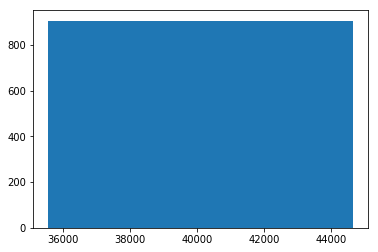

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

idxs_null=df[df['RHMaximum'].isnull()].index
plt.hist(idxs_null) # what does this tell us? 

In [26]:
df.loc[idxs_null]['startDateTime']

35572    2016-07-25T16:51:00Z
35573    2016-07-25T16:52:00Z
35574    2016-07-25T16:53:00Z
35575    2016-07-25T16:54:00Z
35576    2016-07-25T16:55:00Z
35577    2016-07-25T16:56:00Z
35578    2016-07-25T16:57:00Z
35579    2016-07-25T16:58:00Z
35580    2016-07-25T16:59:00Z
35581    2016-07-25T17:00:00Z
35582    2016-07-25T17:01:00Z
35583    2016-07-25T17:02:00Z
35584    2016-07-25T17:03:00Z
35585    2016-07-25T17:04:00Z
35586    2016-07-25T17:05:00Z
35587    2016-07-25T17:06:00Z
35588    2016-07-25T17:07:00Z
35589    2016-07-25T17:08:00Z
35590    2016-07-25T17:09:00Z
35591    2016-07-25T17:10:00Z
35592    2016-07-25T17:11:00Z
35593    2016-07-25T17:12:00Z
35594    2016-07-25T17:13:00Z
35595    2016-07-25T17:14:00Z
35596    2016-07-25T17:15:00Z
35597    2016-07-25T17:16:00Z
35598    2016-07-25T17:17:00Z
35599    2016-07-25T17:18:00Z
35600    2016-07-25T17:19:00Z
35601    2016-07-25T17:20:00Z
                 ...         
44611    2016-07-31T23:30:00Z
44612    2016-07-31T23:31:00Z
44613    2

In [29]:
df=df.iloc[:35572]
df.isnull().sum()

startDateTime       0
endDateTime         0
RHMean              0
RHMinimum           0
RHMaximum           0
RHVariance          0
RHNumPts            0
RHExpUncert         0
RHStdErMean         0
RHFinalQF           0
tempRHMean          0
tempRHMinimum       0
tempRHMaximum       0
tempRHVariance      0
tempRHNumPts        0
tempRHExpUncert     0
tempRHStdErMean     0
tempRHFinalQF       0
dewTempMean         0
dewTempMinimum      0
dewTempMaximum      0
dewTempVariance     0
dewTempNumPts       0
dewTempExpUncert    0
dewTempStdErMean    0
dewTempFinalQF      0
dtype: int64

In [30]:
df.to_csv('rel_humid_ABBY_2017-05.csv')

In [31]:
df[['RHMean','tempRHMean','dewTempMean',
                     'RHStdErMean','tempRHStdErMean','dewTempStdErMean']]

,RHMean,tempRHMean,dewTempMean,RHStdErMean,tempRHStdErMean,dewTempStdErMean
0,58.67,21.301,12.835,0.04,0.003,0.012
1,57.65,21.306,12.571,0.03,0.005,0.008
2,58.14,21.181,12.584,0.02,0.003,0.006
3,58.65,21.133,12.673,0.06,0.001,0.016
4,58.48,21.214,12.702,0.03,0.004,0.006
5,57.61,21.227,12.487,0.04,0.004,0.008
6,58.44,21.153,12.634,0.06,0.001,0.014
7,58.21,21.113,12.537,0.04,0.003,0.008
8,58.44,21.048,12.538,0.01,0.002,0.005
9,59.10,21.023,12.684,0.07,0.003,0.018


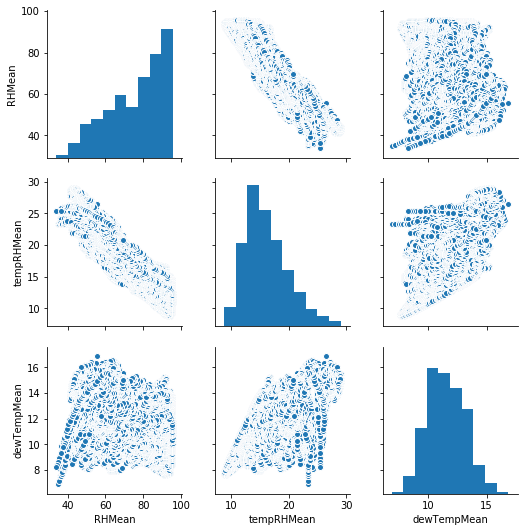

In [40]:
import seaborn as sns 

sns.pairplot(df[['RHMean','tempRHMean','dewTempMean']])

In [41]:
plt.gcf()
plt.savefig('RH_pairplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

###  Task separation and  dependency management  

when scripting a data pipeline, it's helpful to break down the analysis into separate tasks, and identify the dependencies of each task. 


Linear progression of tasks: each task only has one dependency. 

If you have multiple dependencies, then managing everything manually gets messy as the # of tasks increases 

In [2]:
from fastai.structured import *
??proc_df


 
### execute processing step, then save intermediate output during processing 
 
df=proc_df(df_raw)

use /tmp directory if you don't care about intermediate file output. periodically delete these. 

can use the presence/absence of these files as a monitoring tool - know which part(s) of the pipeline are completed 



#### monitoring the processes 

binary outcomes - each sub-task is either complete or not 
 


## Serialization

In [ ]:
## faster, snapshot of memory. new feature in sklearn 20 
df.to_feather('tmp/forest-cover')

## slower, older. pickle is common in the python ecosystem. 
df.to_pickle('tmp/forest-cover-pickle.p') 

# can pickle or feather anything 



## should I run script on my machine or on a cluster?  

#### Memory limitations: 

RAM - what is it and why is it important 

can the data fit in memory? 

HD space - can the data fit on disk? 

If not, use cloud storage or something. but beware IO speed limitations. 

#### Speed limitation - data streaming and processing can fit in memory, but throughput is limited - 

parallelization - multicore or cluster computing 
   
Modern options for cluster computing  - institutional clusters, AWS, google cloud, microsoft azure 

